<a href="https://colab.research.google.com/github/Yashsethi24/Regression-diamond-prices/blob/main/CausalMLAI_Book.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import doubleml as dml
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV, RidgeCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.pipeline import make_pipeline
import warnings

warnings.filterwarnings("ignore")
np.random.seed(772023)

In [47]:
data = pd.read_csv("https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/minwage_data.csv",
                   index_col=0)

In [48]:
# Define the new column names
new_columns = {
    'countyreal': 'county',
    'state_name': 'state',
    'FIPS': 'fips_code',
    'emp0A01_BS': 'employment',
    'censusdiv': 'census_division',
    'pop': 'population',
    'annual_avg_pay': 'avg_annual_pay',
    'state_mw': 'state_min_wage',
    'fed_mw': 'federal_min_wage',
    'treated': 'is_treated',
    'G': 'treatment_year',
    'lemp': 'log_employment',
    'lpop': 'log_population',
    'lavg_pay': 'log_avg_pay',
    'id': 'state_id'
}

# Rename the columns
data = data.rename(columns=new_columns)

## Data Description

- **`county`**: Identifier of the country.  
- **`state`**: Name of the state within the country.  
- **`year`**: Year of the observation.  
- **`fips_code`**: Federal Information Processing Standards (FIPS) code for the county.  
- **`employment`**: This represents the employment level or specific employment measure for the region.  
- **`quarter`**: Quarter of the year (1 to 4).  
- **`census_division`**: Census division for grouping regions in  the county.  
- **`population`**: Total population of the state or region.  
- **`avg_annual_pay`**: Average annual pay for the individual in the division.  
- **`state_min_wage`**: Minimum wage set by the state.  
- **`federal_min_wage`**: Minimum wage set by the federal government.  
- **`is_treated`**: Binary indicator (1 = treated, 0 = control) for whether the state increased its minimum wage.  
- **`treatment_year`**: Year when the state first increased its minimum wage (treatment timing).  
- **`log_employment`**: Natural logarithm of the employment data.  
- **`log_population`**: Natural logarithm of the population.  
- **`log_avg_pay`**: Natural logarithm of the average annual pay.  
- **`region`**: Likely refers to a regional grouping.  
- **`ever_treated`**: Binary indicator (1 = ever treated, 0 = never treated) for whether the state ever increased its minimum wage.  
- **`state_id`**: Unique identifier for each state or region.  

In [49]:
data.head()

,county,state,year,fips_code,employment,quarter,census_division,population,avg_annual_pay,state_min_wage,federal_min_wage,is_treated,treatment_year,log_employment,log_population,log_avg_pay,region,ever_treated,state_id
1,2013,Alaska,2001,2013,15,1,9,2459,22155,5.65,5.15,1,2001,2.708050,7.807510,10.005818,4,1,2013
2,2013,Alaska,2002,2013,17,1,9,2664,28447,5.65,5.15,1,2001,2.833213,7.887584,10.255798,4,1,2013
3,2013,Alaska,2003,2013,12,1,9,2715,30184,7.15,5.15,1,2001,2.484907,7.906547,10.315067,4,1,2013
4,2013,Alaska,2004,2013,13,1,9,2677,27557,7.15,5.15,1,2001,2.564949,7.892452,10.224012,4,1,2013
5,2013,Alaska,2005,2013,11,1,9,2646,30396,7.15,5.15,1,2001,2.397895,7.880804,10.322066,4,1,2013


###
# Convert specified columns to string data type

In [5]:

columns_to_convert = ['county', 'year', 'fips_code', 'employment', 'quarter', 'census_division', 'is_treated', 'treatment_year', 'region', 'ever_treated', 'state_id']

for col in columns_to_convert:
    if col in data.columns:
        data[col] = data[col].astype(str)
    else:
        print(f"Warning: Column '{col}' not found in DataFrame.")

Checking for null values

In [6]:
data.isnull().sum()

,0
county,0
state,0
year,0
fips_code,0
employment,0
quarter,0
census_division,0
population,0
avg_annual_pay,0
state_min_wage,15702


Verifying if null values in state_min_wage are at random or not.

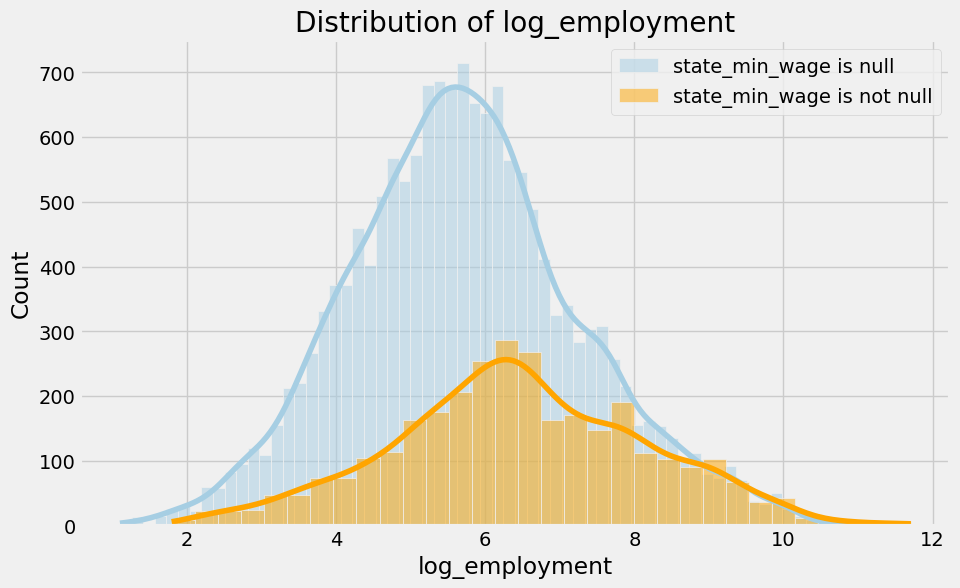

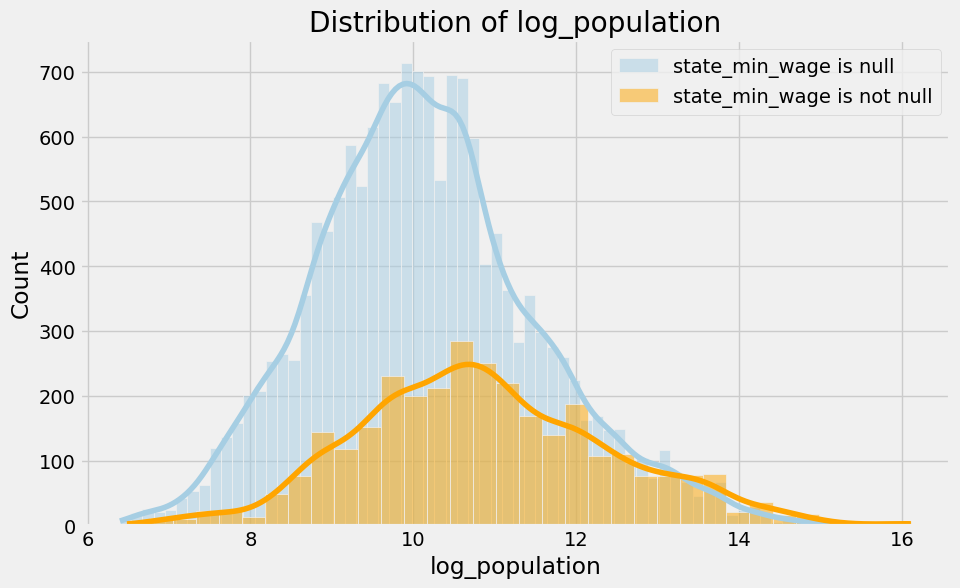

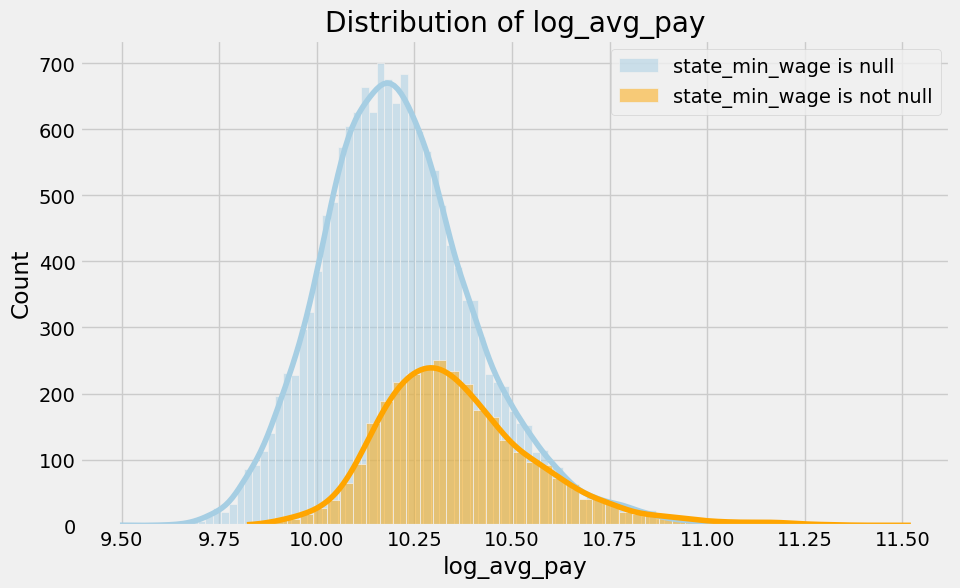

In [7]:
# Separate data into null and non-null state_min_wage groups
null_state_min_wage = data[data['state_min_wage'].isnull()]
non_null_state_min_wage = data[data['state_min_wage'].notnull()]

# Function to plot distributions for specified columns
def plot_distributions(df_null, df_non_null, columns):
    for col in columns:
        plt.figure(figsize=(10, 6))
        sns.histplot(df_null[col], label='state_min_wage is null', kde=True)
        sns.histplot(df_non_null[col], label='state_min_wage is not null', kde=True, color='orange')
        plt.title(f'Distribution of {col}')
        plt.legend()
        plt.show()

# Example usage: plotting distributions for 'log_employment', 'log_population', 'log_avg_pay'
plot_distributions(null_state_min_wage, non_null_state_min_wage, ['log_employment', 'log_population', 'log_avg_pay'])


In [8]:
null_state_min_wage['is_treated'].value_counts()

,count
is_treated,
0,15702


In [9]:
non_null_state_min_wage['is_treated'].value_counts()

,count
is_treated,
1,3149


The above analysis shows that state_min_wage is available for the regions where the treatment was performed. (i.e. minimum wage was increased)

## Univariate analysis

In [33]:
def univariate_analysis(df):
  """Performs univariate analysis on all columns of a DataFrame.

  Args:
    df: The input DataFrame.

  Returns:
    None. Prints the results to the console.
  """

  for col in df.columns:
    print(f"Univariate Analysis for '{col}':")

    if pd.api.types.is_numeric_dtype(df[col]):
      print(f"  Mean: {df[col].mean()}")
      print(f"  Median: {df[col].median()}")
      print(f"  Standard Deviation: {df[col].std()}")
      print(f"  Min: {df[col].min()}")
      print(f"  Max: {df[col].max()}")
      print(f"  25th Percentile: {df[col].quantile(0.25)}")
      print(f"  75th Percentile: {df[col].quantile(0.75)}")
      print("-" * 20)
    elif pd.api.types.is_categorical_dtype(df[col]):
      print(f"  Unique Values: {df[col].unique()}")
      print(f"  Number of Unique Values: {df[col].nunique()}")
      print(f"  Value Counts:\n{df[col].value_counts()}")
      print("-" * 20)
    else:
      print(f"  Unique Values: {df[col].unique()}")
      print(f"  Number of Unique Values: {df[col].nunique()}")
      print(f"  Value Counts:\n{df[col].value_counts()}")
      print("-" * 20)
univariate_analysis(data)


Univariate Analysis for 'county':
  Unique Values: ['2013' '2050' '2060' ... '55141' '55113' '55089']
  Number of Unique Values: 2693
  Value Counts:
county
2013     7
41009    7
40143    7
40079    7
41003    7
        ..
24003    7
24009    7
24001    7
24013    7
55089    7
Name: count, Length: 2693, dtype: int64
--------------------
Univariate Analysis for 'state':
  Unique Values: ['Alaska' 'California' 'Colorado' 'Connecticut' 'Delaware' 'Florida'
 'Georgia' 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas'
 'Louisiana' 'Maine' 'Maryland' 'Michigan' 'Minnesota' 'Missouri'
 'Montana' 'Nebraska' 'Nevada' 'New Jersey' 'New Mexico' 'New York'
 'North Carolina' 'North Dakota' 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania'
 'Rhode Island' 'South Carolina' 'South Dakota' 'Tennessee' 'Texas' 'Utah'
 'Vermont' 'Virginia' 'Washington' 'West Virginia' 'Wisconsin']
  Number of Unique Values: 42
  Value Counts:
state
Texas             1729
Georgia           1092
Virginia           938
Missouri

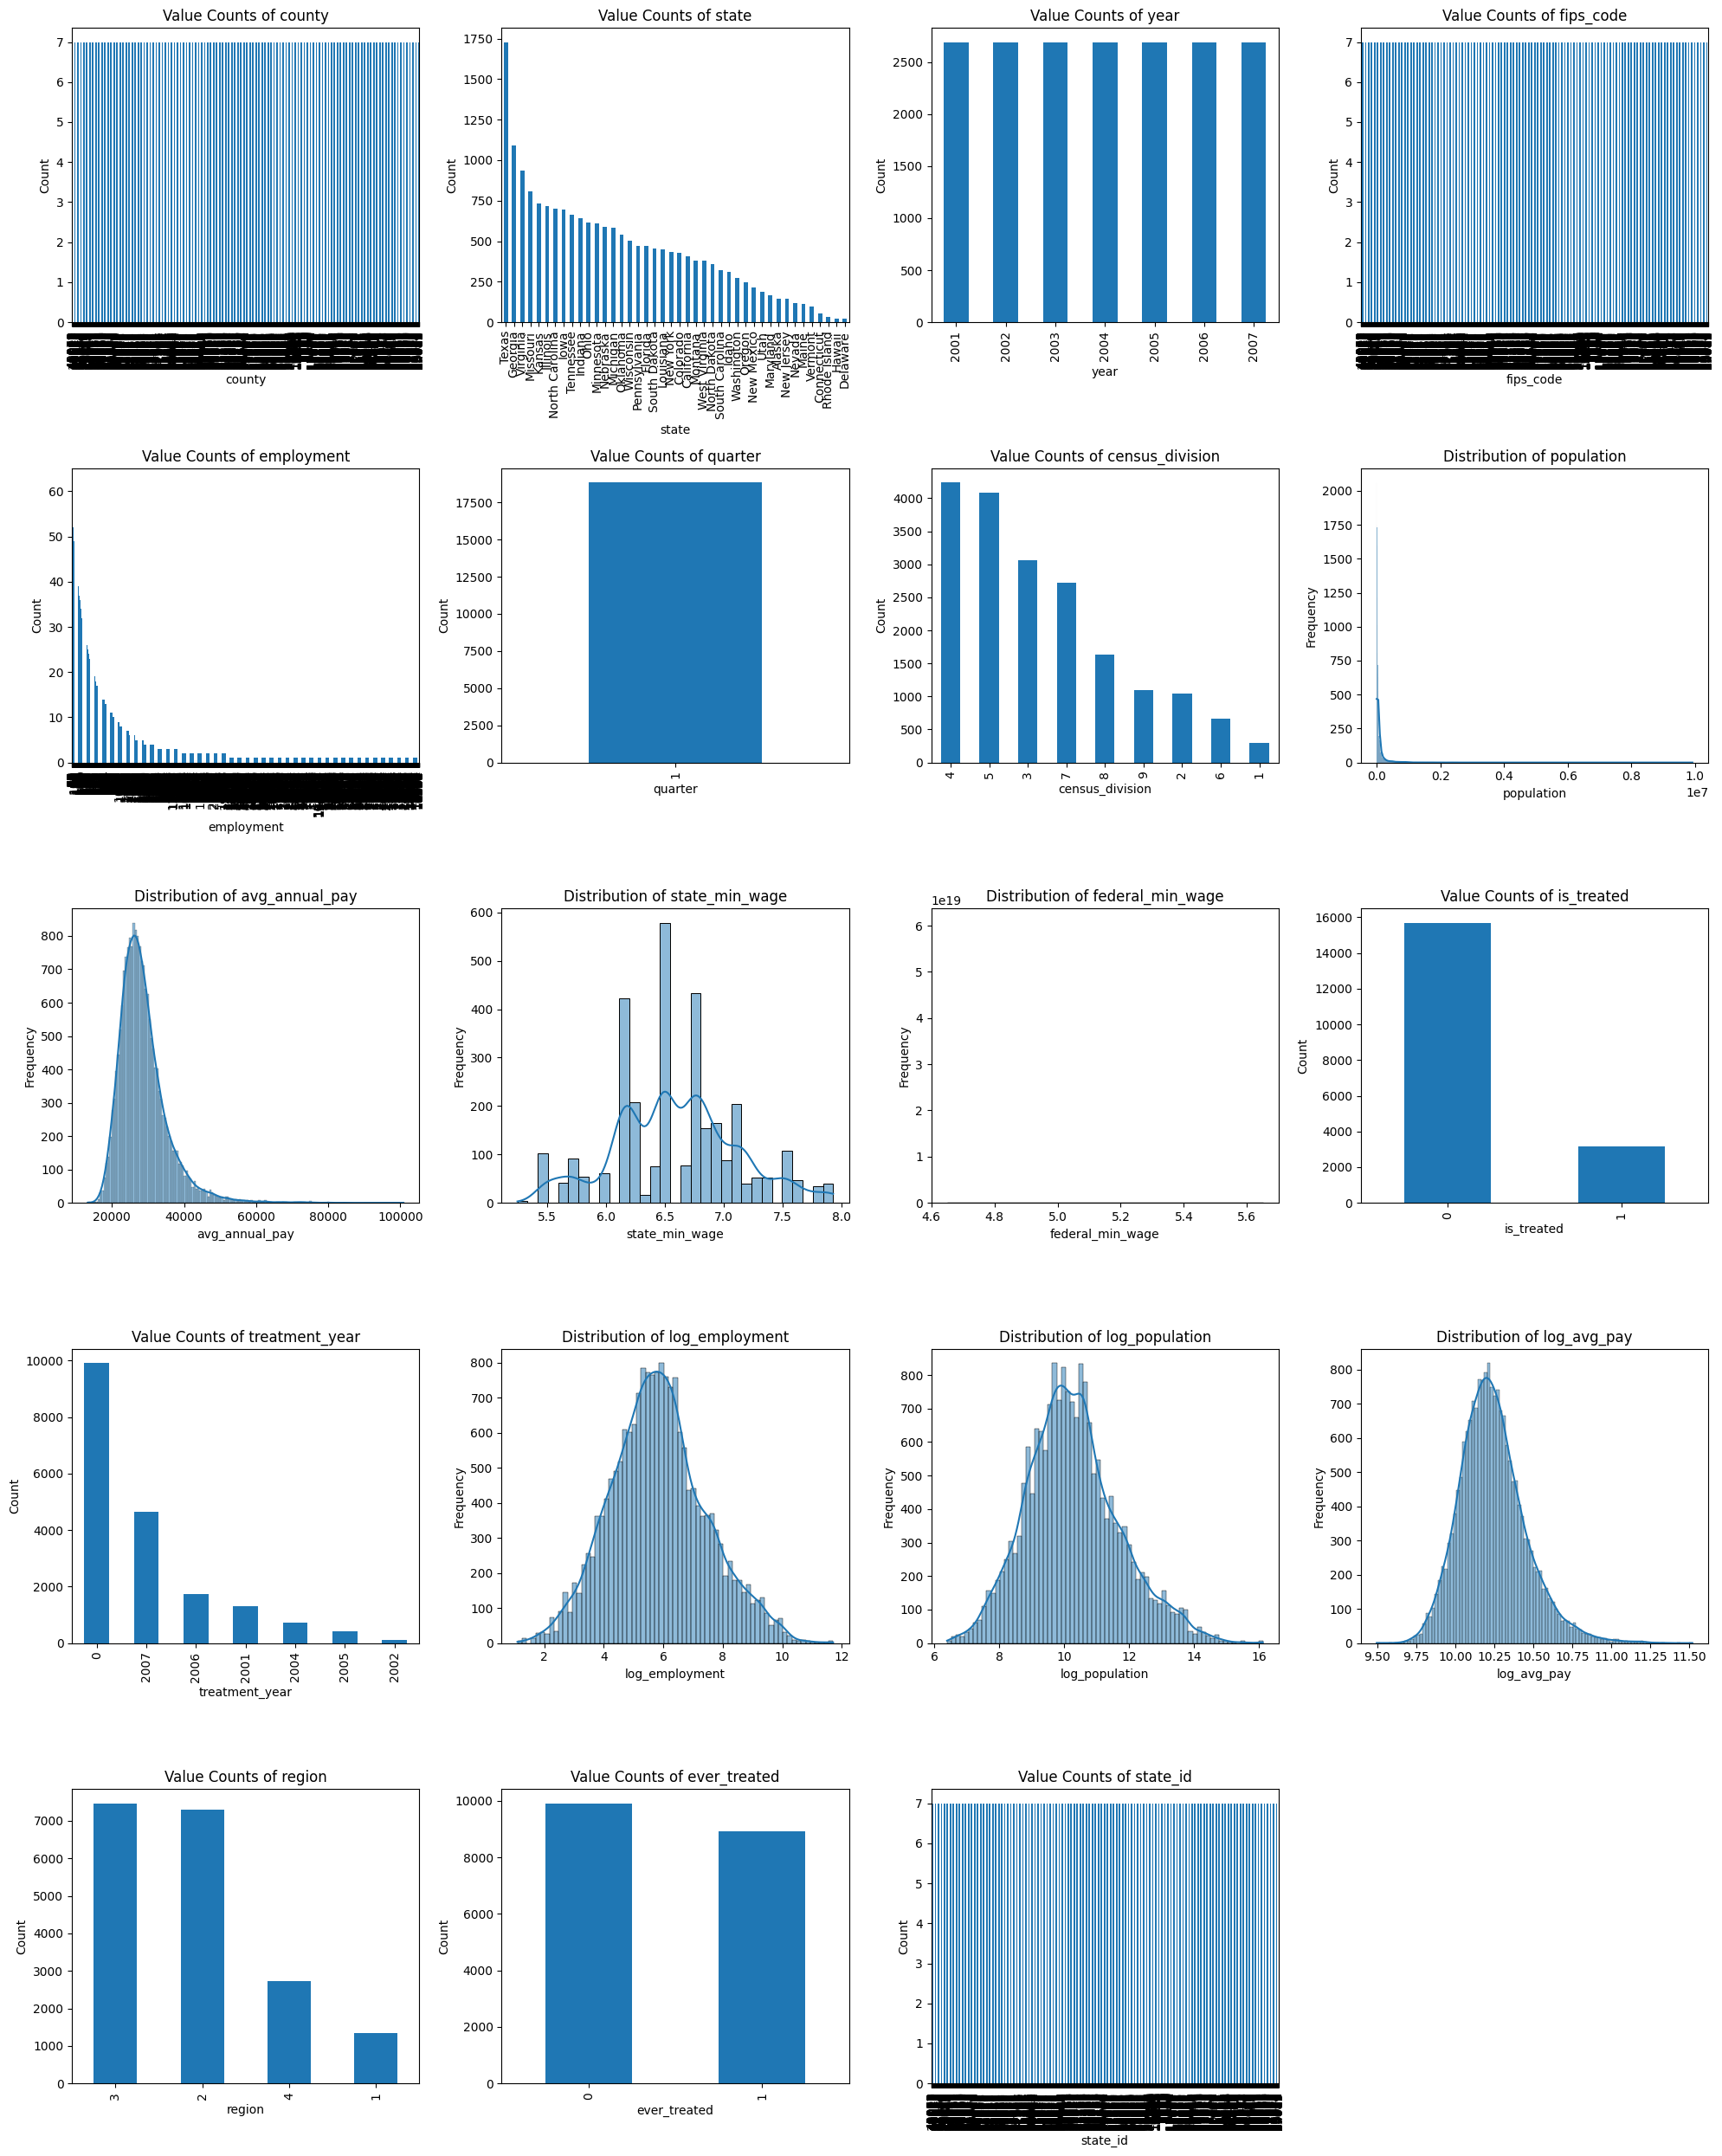

In [42]:

def univariate_analysis(df):
    """Performs univariate analysis and creates graphs in four columns."""
    num_cols = len(df.columns)
    num_rows = (num_cols + 3) // 4  # Calculate the number of rows needed for 4 columns

    fig, axes = plt.subplots(num_rows, 4, figsize=(20, 5 * num_rows))  # Adjust figsize as needed
    axes = axes.ravel() # Flatten the axes array

    for i, col in enumerate(df.columns):
        ax = axes[i]

        if pd.api.types.is_numeric_dtype(df[col]):
            sns.histplot(df[col], kde=True, ax=ax)
            ax.set_title(f'Distribution of {col}')
            ax.set_xlabel(col)
            ax.set_ylabel('Frequency')
        elif pd.api.types.is_categorical_dtype(df[col]) or isinstance(df[col].dtype, object):
            df[col].value_counts().plot(kind='bar', ax=ax)
            ax.set_title(f'Value Counts of {col}')
            ax.set_xlabel(col)
            ax.set_ylabel('Count')

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout() # Adjust layout to prevent overlapping
    plt.show()

univariate_analysis(data)


## Bivariate analysis with Treatment column - is_treated

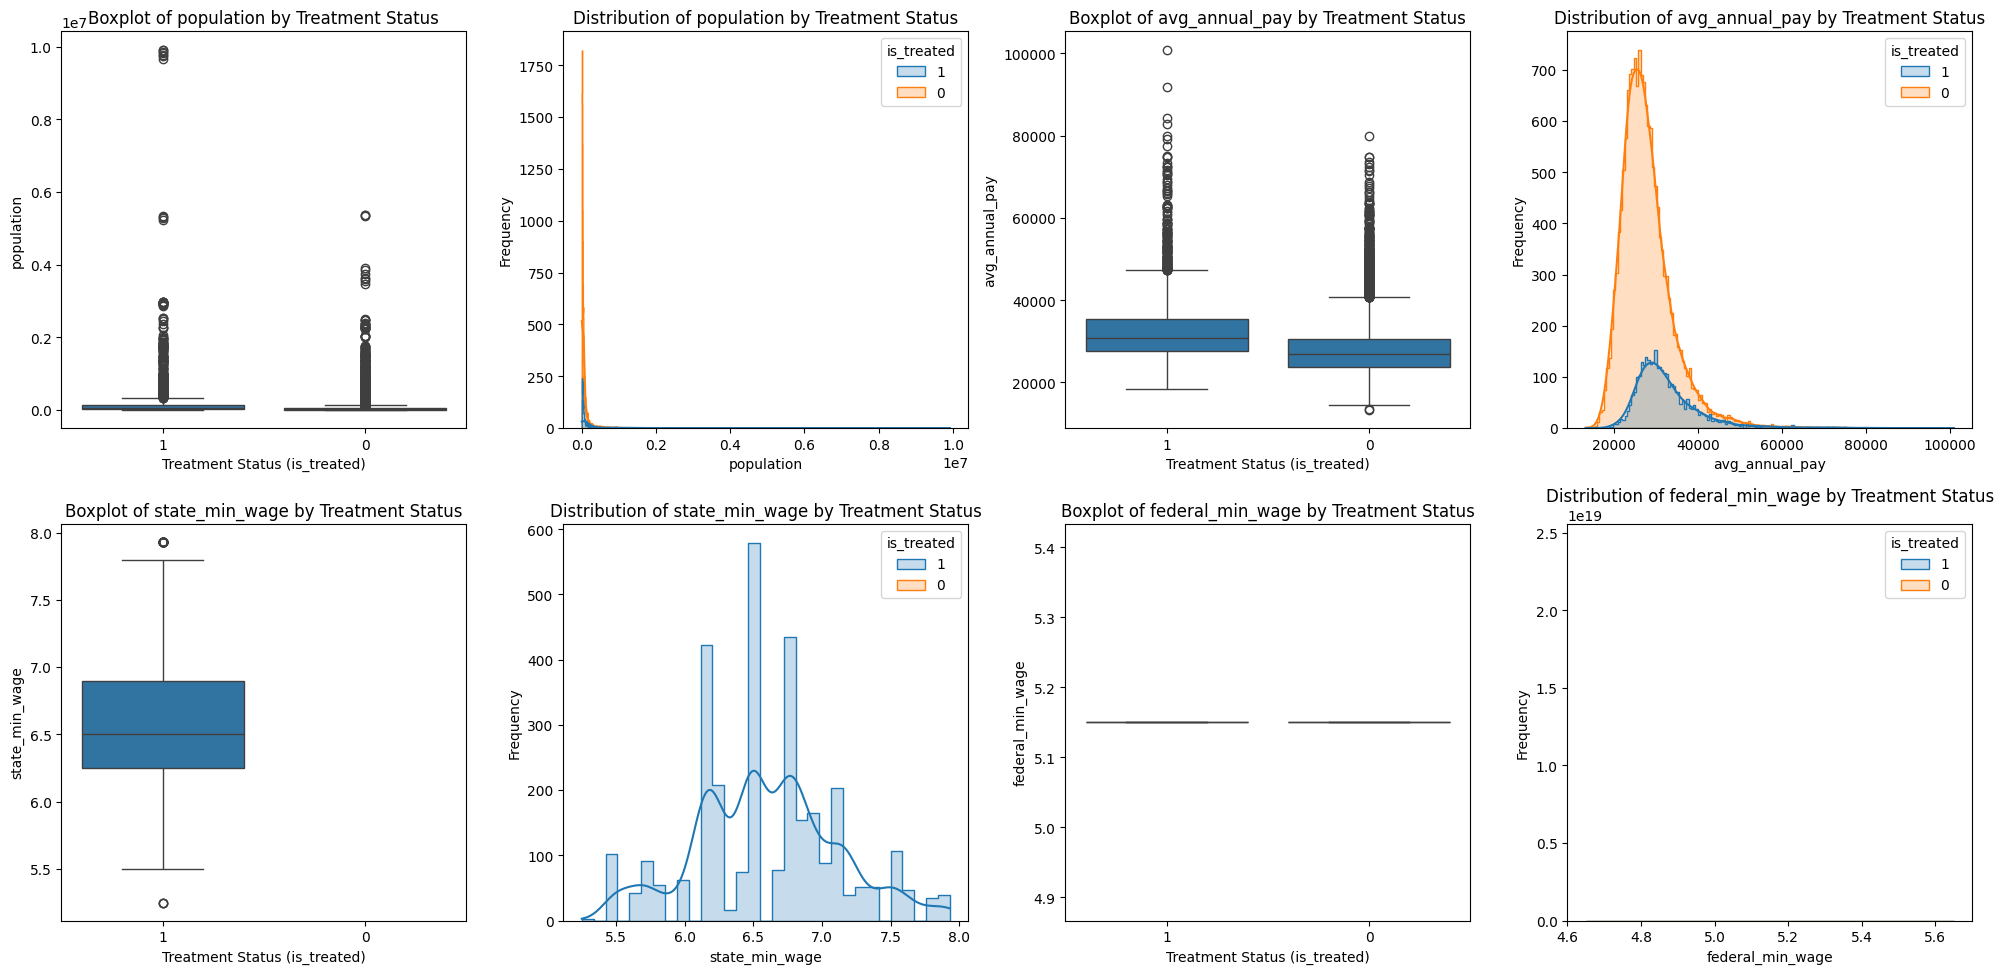

In [45]:
def bivariate_analysis_is_treated(df):
    """
    Performs bivariate analysis with the 'is_treated' column in a 4-column grid.
    """
    num_cols = len([col for col in df.columns if col != 'is_treated' and pd.api.types.is_numeric_dtype(df[col])])
    num_rows = (num_cols + 3) // 4

    fig, axes = plt.subplots(num_rows, 4, figsize=(20, 5 * num_rows))
    axes = axes.ravel()

    col_index = 0
    for col in df.columns:
        if col != 'is_treated' and pd.api.types.is_numeric_dtype(df[col]):
            # Check if the index is within the bounds of the axes array
            if col_index * 2 < len(axes):
                ax1 = axes[col_index * 2]
                ax2 = axes[col_index * 2 + 1]

                sns.boxplot(x='is_treated', y=col, data=df, ax=ax1)
                ax1.set_title(f'Boxplot of {col} by Treatment Status')
                ax1.set_xlabel('Treatment Status (is_treated)')
                ax1.set_ylabel(col)

                sns.histplot(data=df, x=col, hue='is_treated', kde=True, element="step", ax=ax2)
                ax2.set_title(f'Distribution of {col} by Treatment Status')
                ax2.set_xlabel(col)
                ax2.set_ylabel('Frequency')

                col_index += 1
            else:
                break  # Stop the loop if the index is out of bounds

    # Hide any unused subplots
    for j in range(col_index * 2, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

bivariate_analysis_is_treated(data)

In [47]:
data.groupby('is_treated')['federal_min_wage'].value_counts()

,,count
is_treated,federal_min_wage,
0,5.15,15702
1,5.15,3149


## Data Preparation

In [52]:
data.head()

,county,state,year,fips_code,employment,quarter,census_division,population,avg_annual_pay,state_min_wage,federal_min_wage,is_treated,treatment_year,log_employment,log_population,log_avg_pay,region,ever_treated,state_id
1,2013,Alaska,2001,2013,15,1,9,2459,22155,5.65,5.15,1,2001,2.708050,7.807510,10.005818,4,1,2013
2,2013,Alaska,2002,2013,17,1,9,2664,28447,5.65,5.15,1,2001,2.833213,7.887584,10.255798,4,1,2013
3,2013,Alaska,2003,2013,12,1,9,2715,30184,7.15,5.15,1,2001,2.484907,7.906547,10.315067,4,1,2013
4,2013,Alaska,2004,2013,13,1,9,2677,27557,7.15,5.15,1,2001,2.564949,7.892452,10.224012,4,1,2013
5,2013,Alaska,2005,2013,11,1,9,2646,30396,7.15,5.15,1,2001,2.397895,7.880804,10.322066,4,1,2013


In [54]:
data[data['is_treated'] == '0']['treatment_year'].value_counts()

,count
treatment_year,
0,9919
2007,3978
2006,1235
2004,306
2005,248
2002,16


In [55]:
!pip install causalml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.3/144.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: Cython
    Found existing installation: Cython 3.0.11
    Uninstalling Cython-3.0.11:
      Successfully uninstal

In [57]:
import pandas as pd
from causalml.inference.meta import LRSRegressor  # Example: S-Learner with Linear Regression
from xgboost import XGBRegressor  # Example: S-Learner with XGBoost
from causalml.match import create_table_one  # For balance checking
from sklearn.model_selection import train_test_split

In [76]:
X = data[['log_population', 'log_avg_pay', 'federal_min_wage']]  # Features
y = data['log_employment']  # Outcome
treatment = data['is_treated'].astype(int)  # Treatment

X_train, X_test, y_train, y_test, treatment_train, treatment_test = train_test_split(
    X, y, treatment, test_size=0.2, random_state=42
)

In [78]:
# Initialize the S-Learner with Linear Regression
s_learner = LRSRegressor()

# Fit the model
s_learner.fit(X_train, treatment_train, y_train)

# Estimate treatment effects
treatment_effects = s_learner.estimate_ate(X_test, treatment_test, y_test)
print(treatment_effects)

(array([-0.02415121]), array([-0.06213994]), array([0.01383753]))


In [79]:
table_one = create_table_one(data, 'is_treated', ['log_population', 'log_avg_pay'])
print(table_one)

                     Control     Treatment  SMD
Variable                                       
n                      15702          3149     
log_avg_pay     10.21 (0.20)  10.37 (0.21)  NaN
log_population  10.16 (1.38)  10.88 (1.55)  NaN


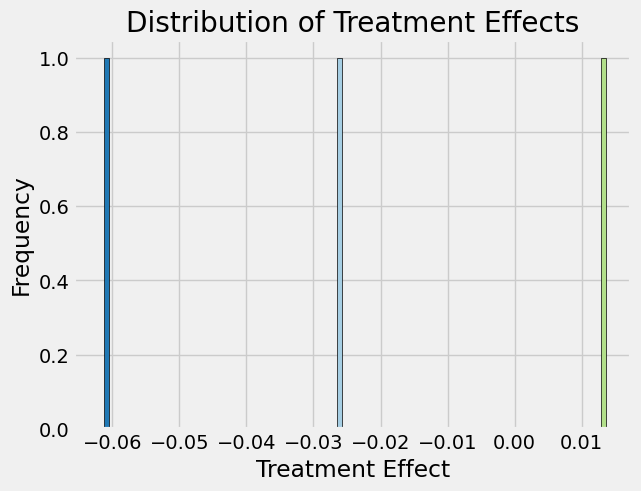

In [80]:
import matplotlib.pyplot as plt

plt.hist(treatment_effects, bins=30, edgecolor='k')
plt.title('Distribution of Treatment Effects')
plt.xlabel('Treatment Effect')
plt.ylabel('Frequency')
plt.show()

In [83]:
X = data[['log_population', 'log_avg_pay', 'federal_min_wage']]  # Features
y = data['log_employment']  # Outcome
T = data['is_treated'].astype(int)  # Treatment

X_train, X_test, y_train, y_test, treatment_train, treatment_test = train_test_split(
    X, y, treatment, test_size=0.2, random_state=42
)

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor
import shap
from xgboost import XGBClassifier
from causalml.inference.tree import UpliftTreeClassifier
from causalml.inference.tree import UpliftRandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor, IsolationForest
from causalml.inference.meta import LRSRegressor, BaseSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import LRSRegressor, BaseTRegressor, BaseXRegressor, slearner
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.metrics import *
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import entropy
import warnings
from sklearn.neural_network import MLPRegressor
from causalml.propensity import ElasticNetPropensityModel
from econml.metalearners import SLearner, TLearner
from econml.dml import CausalForestDML, LinearDML

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
ERROR:duecredit:Failed to import duecredit due to No module named 'duecredit'


In [88]:
!pip install econml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.4/117.4 kB 10.9 MB/s eta 0:00:00
  Attempting uninstall: slicer
    Found existing installation: slicer 0.0.8
    Uninstalling slicer-0.0.8:
      Successfully uninstalled slicer-0.0.8
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: shap
    Found existing installation: shap 0.46.0
    Uninstalling shap-0.46.0:
      Successfully uninstalled shap-0.46.0


In [50]:
# Filter out irrelevant periods and ensure we only have treated and untreated observations
data = data[(data['treatment_year'].astype(int) == 0) | (data['treatment_year'].astype(int) == 2004)]  # G = 0 (control) or G = 2004 (treated)

In [51]:
years = [2001, 2002, 2003, 2004, 2005, 2006, 2007]
treat, cont = {}, {}
for year in years:
    treat[year] = data.loc[(data.treatment_year.astype('int') == 2004) & (data.year.astype('int') == year)].copy()
    cont[year] = data.loc[((data.treatment_year.astype('int') == 0) | (data.treatment_year.astype('int') > year)) & (data.year.astype('int')  == year)].copy()

In [52]:
treat[2004]['treatment_year'].unique()

array([2004])

In [53]:
cont[2001]['treatment_year'].unique()

array([   0, 2004])

In [39]:
data[data['year'] == '2004'].shape

(2693, 19)

In [55]:
data.groupby('treatment_year')['is_treated'].unique()

,is_treated
treatment_year,
0,[0]
2004,"[0, 1]"


In [56]:
X = data[['log_population', 'log_avg_pay', 'federal_min_wage']]  # Confounders
y = data['log_employment']  # Outcome
treatment = data['is_treated']  # Treatment

In [57]:
X_train, X_test, y_train, y_test, treatment_train, treatment_test = train_test_split(
    X, y, treatment, test_size=0.2, random_state=42
)


In [58]:
from causalml.inference.meta import LRSRegressor

s_learner = LRSRegressor()
s_learner.fit(X_train, treatment_train, y_train)
treatment_effects = s_learner.estimate_ate(X_test, treatment_test, y_test)

print("Estimated Treatment Effect:", treatment_effects)


Estimated Treatment Effect: (array([-0.09090906]), array([-0.18512792]), array([0.0033098]))


In [59]:
from causalml.inference.meta import BaseTRegressor

t_learner = BaseTRegressor()
t_learner.fit(X_train, treatment_train, y_train)
treatment_effects = t_learner.estimate_ate(X_test, treatment_test, y_test)

print("Estimated Treatment Effect:", treatment_effects)


AssertionError: 

In [60]:
from causalml.inference.meta import BaseXRegressor

x_learner = BaseXRegressor()
x_learner.fit(X_train, treatment_train, y_train)
treatment_effects = x_learner.estimate_ate(X_test, treatment_test, y_test)

print("Estimated Treatment Effect:", treatment_effects)


AssertionError: 

In [61]:
from econml.dml import LinearDML
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor

dml = LinearDML(model_y=RandomForestRegressor(),
                model_t=LogisticRegression(),
                discrete_treatment=True)
dml.fit(y_train, treatment_train, X=X_train)
ate = dml.ate(X_test)
print("Average Treatment Effect (ATE):", ate)


Average Treatment Effect (ATE): -0.021424934479925856


Co-variance matrix is underdetermined. Inference will be invalid!


In [62]:
# Ready-to-use S-Learner using LinearRegression
learner_s = LRSRegressor()
ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y)
print(ate_s)
print('ATE estimate: {:.03f}'.format(ate_s[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_s[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_s[2][0]))

# After calling estimate_ate, add pretrain=True flag to skip training
# This flag is applicable for other meta learner
ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y, pretrain=True)
print(ate_s)
print('ATE estimate: {:.03f}'.format(ate_s[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_s[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_s[2][0]))

(array([-0.00579294]), array([-0.04527661]), array([0.03369073]))
ATE estimate: -0.006
ATE lower bound: -0.045
ATE upper bound: 0.034
(array([-0.00579294]), array([-0.04527661]), array([0.03369073]))
ATE estimate: -0.006
ATE lower bound: -0.045
ATE upper bound: 0.034


In [63]:
# Ready-to-use T-Learner using XGB
learner_t = XGBTRegressor()
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the ready-to-use XGBTRegressor class')
print(ate_t)

# Calling the Base Learner class and feeding in XGB
learner_t = BaseTRegressor(learner=XGBRegressor())
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseTRegressor class and using XGB (same result):')
print(ate_t)

# Calling the Base Learner class and feeding in LinearRegression
learner_t = BaseTRegressor(learner=LinearRegression())
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseTRegressor class and using Linear Regression (different result):')
print(ate_t)

Using the ready-to-use XGBTRegressor class
(array([-0.16301566]), array([-0.17572891]), array([-0.15030242]))

Using the BaseTRegressor class and using XGB (same result):
(array([-0.16301566]), array([-0.17572891]), array([-0.15030242]))

Using the BaseTRegressor class and using Linear Regression (different result):
(array([-0.05453845]), array([-0.0907846]), array([-0.0182923]))


In [64]:
# X Learner with propensity score input
# Calling the Base Learner class and feeding in XGB
learner_x = BaseXRegressor(learner=XGBRegressor())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p=e)
print('Using the BaseXRegressor class and using XGB:')
print(ate_x)

# Calling the Base Learner class and feeding in LinearRegression
learner_x = BaseXRegressor(learner=LinearRegression())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p=e)
print('\nUsing the BaseXRegressor class and using Linear Regression:')
print(ate_x)

NameError: name 'e' is not defined

In [65]:
# X Learner without propensity score input
# Calling the Base Learner class and feeding in XGB
learner_x = BaseXRegressor(XGBRegressor())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the BaseXRegressor class and using XGB without propensity score input:')
print(ate_x)

# Calling the Base Learner class and feeding in LinearRegression
learner_x = BaseXRegressor(learner=LinearRegression())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseXRegressor class and using Linear Regression without propensity score input:')
print(ate_x)

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

Using the BaseXRegressor class and using XGB without propensity score input:
(array([-0.15001064]), array([-0.1620063]), array([-0.13801498]))


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the


Using the BaseXRegressor class and using Linear Regression without propensity score input:
(array([-0.05453845]), array([-0.0907846]), array([-0.0182923]))


In [67]:

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import *
from causalml.metrics import *

In [68]:
# R Learner with propensity score input
# Calling the Base Learner class and feeding in XGB
learner_r = BaseRRegressor(learner=XGBRegressor())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=e)
print('Using the BaseRRegressor class and using XGB:')
print(ate_r)

# Calling the Base Learner class and feeding in LinearRegression
learner_r = BaseRRegressor(learner=LinearRegression())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=e)
print('Using the BaseRRegressor class and using Linear Regression:')
print(ate_r)

NameError: name 'e' is not defined

In [69]:
# R Learner without propensity score input
# Calling the Base Learner class and feeding in XGB
learner_r = BaseRRegressor(learner=XGBRegressor())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the BaseRRegressor class and using XGB without propensity score input:')
print(ate_r)

# Calling the Base Learner class and feeding in LinearRegression
learner_r = BaseRRegressor(learner=LinearRegression())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the BaseRRegressor class and using Linear Regression without propensity score input:')
print(ate_r)

Using the BaseRRegressor class and using XGB without propensity score input:
(array([-0.14838811]), array([-0.14879025]), array([-0.14798596]))
Using the BaseRRegressor class and using Linear Regression without propensity score input:
(array([-0.03800256]), array([-0.03838184]), array([-0.03762329]))


In [13]:
X = data[['log_population', 'log_avg_pay', 'federal_min_wage']]  # Features
Y = data['log_employment']  # Outcome
T = data['is_treated'].astype(int)  # Treatment

X_train, X_test, y_train, y_test, treatment_train, treatment_test = train_test_split(
    X, y, treatment, test_size=0.2, random_state=42
)

In [15]:
#4. CATE Estimation with S/T/R-Learners
# S-Learner (XGBoost)
s_learner_xgb = SLearner(overall_model=XGBRegressor(n_estimators=100))
s_learner_xgb.fit(Y, T, X=X)
cate_s_xgb = s_learner_xgb.effect(X)

In [16]:
# S-Learner (MLP)
s_learner_mlp = SLearner(overall_model=MLPRegressor(hidden_layer_sizes=(50, 25), max_iter=500))
s_learner_mlp.fit(Y, T, X=X)
cate_s_mlp = s_learner_mlp.effect(X)

In [17]:
# T-Learner (XGBoost)
t_learner_xgb = TLearner(models=[XGBRegressor(), XGBRegressor()])  # Control/Treated models
t_learner_xgb.fit(Y, T, X=X)
cate_t_xgb = t_learner_xgb.effect(X)

In [18]:
# T-Learner (MLP)
t_learner_mlp = TLearner(models=[MLPRegressor(hidden_layer_sizes=(50, 25), max_iter=500),
                                 MLPRegressor(hidden_layer_sizes=(50, 25), max_iter=500)])
t_learner_mlp.fit(Y, T, X=X)
cate_t_mlp = t_learner_mlp.effect(X)


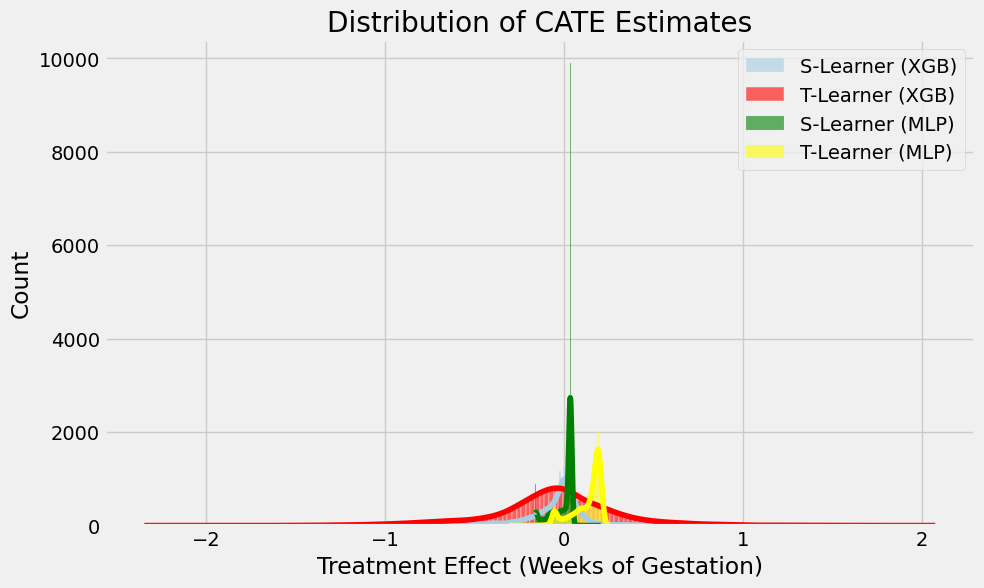

In [19]:
# 5. Heterogeneous Treatment Effect Analysis
# Plot CATE distributions
plt.figure(figsize=(10, 6))
sns.histplot(cate_s_xgb, kde=True, label='S-Learner (XGB)', alpha=0.6)
sns.histplot(cate_t_xgb, kde=True, label='T-Learner (XGB)', color='red', alpha=0.6)
sns.histplot(cate_s_mlp, kde=True, label='S-Learner (MLP)', color='green', alpha=0.6)
sns.histplot(cate_t_mlp, kde=True, label='T-Learner (MLP)', color='yellow', alpha=0.6)
plt.title("Distribution of CATE Estimates")
plt.xlabel("Treatment Effect (Weeks of Gestation)")
plt.legend()
plt.show()

In [ ]:
# 1. Fit S-learner
s_learner = SLearner(overall_model=XGBRegressor(n_estimators=100))
s_learner.fit(Y, T, X=X_transformed)

# 2. Get CATE predictions
cate_predictions = s_learner.effect(X_transformed)

# 3. Create and fit surrogate model
surrogate_model = GradientBoostingRegressor(n_estimators=100)
surrogate_model.fit(X_transformed, cate_predictions)

# 4. Create SHAP explainer
explainer = shap.TreeExplainer(surrogate_model)
shap_values = explainer.shap_values(X_transformed)

# 5. Calculate feature importance based on mean absolute SHAP values
feature_importance = np.abs(shap_values).mean(axis=0)

# 6. Create visualizations
plt.figure(figsize=(10, 6))
shap.summary_plot(
      shap_values,
      X_transformed,
      feature_names=confounders if confounders is not None else [f"Feature {i}" for i in range(X_transformed.shape[1])],
      show=False
)
plt.title("SHAP Values for S-Learner CATE Estimates")
plt.tight_layout()

feature_names = confounders
    # 7. Create feature importance bar plot
plt.figure(figsize=(10, 6))
if feature_names is not None:
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': feature_importance
        })
else:
        importance_df = pd.DataFrame({
            'Feature': [f"Feature {i}" for i in range(len(feature_importance))],
            'Importance': feature_importance
        })

importance_df = importance_df.sort_values('Importance', ascending=True)
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title('Feature Importance Based on SHAP Values')
plt.xlabel('Mean |SHAP Value|')
plt.tight_layout()

In [85]:
!pip install scikit-learn --upgrade